# Классификация персонажей Симпсонов с использованием глубокого обучения

## Описание проекта
Этот проект представляет собой решение задачи компьютерного зрения по классификации изображений персонажей мультсериала "Симпсоны".

**Задача**: Создать модель глубокого обучения, способную с высокой точностью определять, какой из более чем 40 персонажей Симпсонов изображен на фотографии.

**Контекст**: С момента выхода первого эпизода в 1989 году стиль анимации и внешний вид персонажей значительно изменились, что делает задачу классификации особенно интересной с точки зрения машинного обучения.


В нашем тесте будет 991 картинка, для которых вам будет необходимо предсказать класс.

## Шаг 1. Установка зависимостей

####Установим необходимые библиотеки и проверим доступность CUDA

In [ ]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
!nvidia-smi

Mon Nov 17 17:00:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8             13W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from torchvision.transforms import v2

import torchsummary

from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from tqdm.notebook import tqdm

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


#### Проверим версии Python и библиотек
Посмотрим, какие версии установлены:

In [ ]:
!python --version
from importlib.metadata import version
for b in ['torch', 'torchvision', 'tqdm', 'matplotlib', 'seaborn', 'Pillow']:
    print(b + ' version: '+ version(b))

Python 3.12.12
torch version: 2.8.0+cu126
torchvision version: 0.23.0+cu126
tqdm version: 4.67.1
matplotlib version: 3.10.0
seaborn version: 0.13.2
Pillow version: 11.3.0


Сверим с версиями питона и библиотек, на которых работал эталонный ноутбук:

- Python 3.12.12
- torch version: 2.8.0+cu126
- torchvision version: 0.23.0+cu126
- tqdm version: 4.67.1
- matplotlib version: 3.10.0
- seaborn version: 0.13.2
- Pillow version: 11.3.0


 #### Определим константы, которые будем использовать в по ходу ноутбука

In [ ]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']

# работаем на видеокарте
DEVICE = torch.device("cuda")

#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('/content/train') #Path('./data/train/')
TEST_DIR = Path('/content/testset') #Path('./data/testset')

# параметры нормировки изображений по трем каналам перед подачей в модель
NORMALIZE_MEAN = [0.485, 0.456, 0.406]
NORMALIZE_STD = [0.229, 0.224, 0.225]

# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = [224, 224]

## Шаг 2. Загрузка и обработка данных

#### Скачаем изображения по ссылке

In [ ]:
!gdown 1RxBQiZgRAfio2tWhEE7lzZ6IaJzLheH1

Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1RxBQiZgRAfio2tWhEE7lzZ6IaJzLheH1

but Gdown can't. Please check connections and permissions.


- Если не получается скачать, то можно загрузить датасет из своего гугл диска.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


- Код для того, чтобы убедиться, что на гугл диске предварительно был скачен файл

In [ ]:
!ls -la "/content/drive/MyDrive/"

total 537802
-rw------- 1 root root   1309227 Dec 13  2024  4FF6B1B5-4C0C-45C7-9055-6FF890BF71E7.jpeg
-rw------- 1 root root   1307061 Dec 13  2024  8DFAB337-9F0B-4096-8AF5-FDBBB2027F1E.jpeg
-rw------- 1 root root   1258986 Dec 13  2024  A1972DB5-856D-46D2-8059-AED10C0967B5.jpeg
drwx------ 2 root root      4096 Sep  4  2024 'Colab Notebooks'
-rw------- 1 root root       177 Aug 19 16:59 'DLS ссылки на видео.gsheet'
-rw------- 1 root root    602709 Oct  4 13:40  Don’tGetKicked.ipynb
-rw------- 1 root root 546224286 Nov 14 11:51  journey-springfield.zip
-rw------- 1 root root       177 Dec 22  2024 'Копия New Operating System Design Pitch Deck by Slidesgo (1).gslides'
-rw------- 1 root root       177 Dec 22  2024 'Копия New Operating System Design Pitch Deck by Slidesgo.gslides'


- Копирование файла в рабочую дирректорию

In [ ]:
!cp "/content/drive/MyDrive/journey-springfield.zip" "/content/"

In [ ]:
!ls -la "/content/journey-springfield.zip"

-rw------- 1 root root 546224286 Nov 17 17:01 /content/journey-springfield.zip


In [ ]:
!unzip -q /content/journey-springfield.zip

Посмотрите на структуру файлов в папках train и testset.

В train лежат данные, которые мы будем использовать для обучения модели. Изображения персонажей разложены по папкам, которые названы по именам персонажей. Названия папок мы в дальнейшем будет использовать в качестве текстовых меток классов.

В testset находятся изображения, для которых вам надо будет сделать прогноз наиболее вероятного класса.


Для обращения к файлам сформируем списки имен файлов обучающей+валидационнной и тестовой выборок. Это полные имена, включающие путь к файлам.


In [ ]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

Кодировать имена персонажей в числовые метки класса и обратно будем при помощи `LabelEncoder`.

Для train выборки сформируем список текстовых меток всех изображений - имя родительской директории, которая одновременно является и именем персонажа. Зададим числовые метки классов нашего энкодера при помощи метода `fit`.

Далее будем применять метод `transform` для преобразования текстовых меток в числовые, и метод `inverse_transform` для преобразования числовых меток в текстовые.


In [ ]:
label_encoder = LabelEncoder()

train_val_labels = [path.parent.name for path in train_val_files]

label_encoder.fit(train_val_labels)

LabelEncoder()

Разделим train выборку на обучающую и валидационнную части. Для того, чтобы персонажи были пропорционально представлены в обучающей и валидационнной подвыборках, применим стратификацию по меткам класса.

In [ ]:
from sklearn.model_selection import train_test_split

train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

####Создадим Datasets и Dataloaders

In [ ]:
class SimpsonsDataset(Dataset):
    def __init__(self, files, label_encoder, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode
        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.label_encoder = label_encoder
        self.len_ = len(self.files)

    def __len__(self):
        return self.len_

    def __getitem__(self, index):
        x = self.load_image(self.files[index])
        x = self.transform_images_to_tensors(x)

        if self.mode == 'test':
            return x
        else:
            path = self.files[index]
            y = self.label_encoder.transform([path.parent.name,]).item()
            return x, y

    # принимает путь к файлу изображения и возвращает само изображение
    def load_image(self, file):
        image = Image.open(file)
        image.load()
        tensor = v2.functional.pil_to_tensor(image).to(DEVICE)  # Добавим для ускорения обучения
        return tensor #выводим тензор


    # преобразует изображение в тензор
    def transform_images_to_tensors(self, image):
      if self.mode == 'train':
        transform = v2.Compose([
            #v2.PILToTensor(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
            #v2.ColorJitter(brightness = 0.1, contrast = 0.1, saturation = 0.1),
            v2.Resize(RESCALE_SIZE),
          ])
      else:
        transform = v2.Compose([
            #v2.PILToTensor(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
            v2.Resize(RESCALE_SIZE),
          ])

      tensor_transformed = transform(image)
      return(tensor_transformed)


In [ ]:
train_dataset = SimpsonsDataset(train_files, label_encoder = label_encoder, mode='train')
val_dataset = SimpsonsDataset(val_files, label_encoder, mode='val')

In [ ]:
batch_size = 64

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
loaders = {'train':train_loader, 'val': val_loader}

#### Посмотрим на изображения персонажей

Напишем функцию для визуализации картинок. Это аналог Imshow, которая будет принимать на вход тензоры

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

Проверим, как работает наша функция. Возьмем один батч из лоадера и подадим на вход функции первый тензор из этого батча. Заодно посмотрим, как работает кодировщик меток класса.

Числовая метка класса: 0
Текстовая метка класса: ['abraham_grampa_simpson']


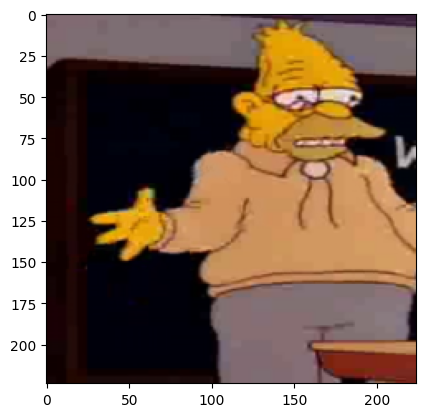

In [ ]:
image_tensor, label = next(iter(train_loader))
print(f"Числовая метка класса: {label[0]}")
print(f"Текстовая метка класса: {label_encoder.inverse_transform([label[0],])}")
imshow(image_tensor[0])


In [ ]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions):
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

In [ ]:
def show_images(n_rows, n_cols, dataset):
  # функция выводит изображения в n_rows рядов и n_cols столбцов
  fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 4, n_rows * 4), \
                        sharey=True, sharex=True)

  for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, len(dataset)))
    im_val, label = dataset[random_characters] # получаем изображение (тензорная форма)
    img_label = " ".join(map(lambda x: x.capitalize(), \
                             label_encoder.inverse_transform([label])[0].split('_')))  # числовую метку класса преобразуем в текстовую и немного отформатируем
    imshow(im_val.data.cpu(), title=img_label, plt_ax=fig_x) # отобразим изображение и метку класса с помощью написанной ранее функции imshow()
    fig_x.set_axis_off()
  return None

Запустим написанную функцию

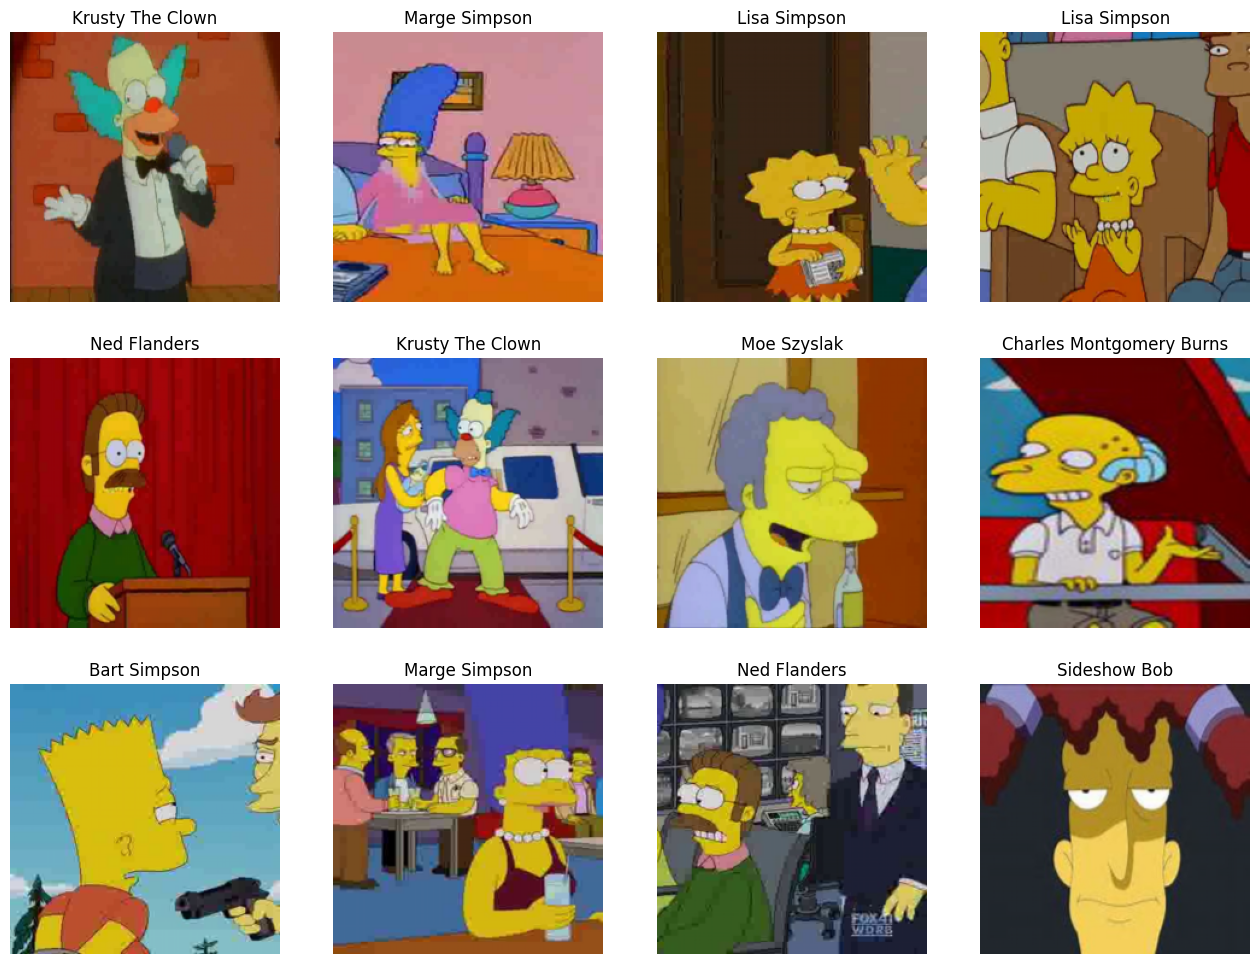

In [ ]:
show_images(n_rows = 3, n_cols = 4, dataset = val_dataset)

## Шаг 3. Построение нейросети

Построим базовую простую модель, затем будем ее усложнять

#### Модель

Эта сеть состоит из пяти сверточных слоев, каждый из которых включает в себя операцию свертки, функцию активации ReLU и операцию пулинга (max-pooling). На выходе используется полносвязный слой для классификации на заданное количество классов.

In [ ]:
class SimpleCnn(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.Linear(96 * 5 * 5, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

*Описание слоев*:

1. размерность входа: $3\times 224 \times 224$
2. размерность после 1-го слоя (Conv2d + ReLU + MaxPool2d):  $8 \times 111 \times 111$
3. после 2-го слоя: $16 \times 54 \times 54$
4. после 3-го слоя: $32 \times 26 \times 26$
5. после 4-го слоя: $64 \times 12 \times 12$
6. после 5-го слоя: $96 \times 5 \times 5$
7. после полносвязного слоя (выход модели): количество классов

In [ ]:
model_simple_cnn = SimpleCnn(n_classes = len(np.unique(train_val_labels)))
model_simple_cnn.to(DEVICE)
torchsummary.summary(model_simple_cnn, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 222, 222]             224
              ReLU-2          [-1, 8, 222, 222]               0
         MaxPool2d-3          [-1, 8, 111, 111]               0
            Conv2d-4         [-1, 16, 109, 109]           1,168
              ReLU-5         [-1, 16, 109, 109]               0
         MaxPool2d-6           [-1, 16, 54, 54]               0
            Conv2d-7           [-1, 32, 52, 52]           4,640
              ReLU-8           [-1, 32, 52, 52]               0
         MaxPool2d-9           [-1, 32, 26, 26]               0
           Conv2d-10           [-1, 64, 24, 24]          18,496
             ReLU-11           [-1, 64, 24, 24]               0
        MaxPool2d-12           [-1, 64, 12, 12]               0
           Conv2d-13           [-1, 96, 10, 10]          55,392
             ReLU-14           [-1, 96,

##Шаг 4. Функции для работы с моделью

In [ ]:
from sklearn.metrics import f1_score

- Функция для обучения модели на одной эпохе

In [ ]:
def train_one_epoch(model, train_dataloader, optimizer, criterion):
  model.train()
  labels_preds = []
  true_labels = []
  for x_batch, y_batch in tqdm(train_dataloader):
    x_batch = x_batch.to(DEVICE)
    y_batch = y_batch.to(DEVICE)

    optimizer.zero_grad()
    output = model(x_batch)

    loss = criterion(output, y_batch)
    loss.backward()
    optimizer.step()

    pred_one_batch = output.argmax(-1) # Предсказанный класс для каждого изображения в батче
    labels_preds.append(pred_one_batch.cpu())
    true_labels.append(y_batch.cpu())

  labels_preds = torch.cat(labels_preds)
  true_labels = torch.cat(true_labels)
  return labels_preds, true_labels

- Функция для валидации модели на одной эпохе

In [ ]:
def eval_one_epoch(model, val_dataloader):
  model.eval()
  labels_preds = []
  true_labels = []
  for x_batch, y_batch in tqdm(val_dataloader):
      x_batch = x_batch.to(DEVICE)
      y_batch = y_batch.to(DEVICE)
      with torch.no_grad():
        output = model(x_batch)
        pred_one_batch = output.argmax(-1)
        labels_preds.append(pred_one_batch.cpu())
        true_labels.append(y_batch.cpu())

  labels_preds = torch.cat(labels_preds)
  true_labels = torch.cat(true_labels)
  return labels_preds, true_labels

- Функция для полного цикла обучения модели

In [ ]:
def full_cycle_train(model, dataloaders, optimizer, loss_func, max_epochs):
  model.to(DEVICE)
  f1_scores = {"train": [], "valid": []}
  for epoch in range(max_epochs):
    print(f"\nEpoch: {epoch+1}")

    y_pred_train, y_true_train = train_one_epoch(model = model, train_dataloader = dataloaders['train'], optimizer = optimizer, criterion = loss_func)
    f1_train_one_epoch = f1_score(y_true_train.numpy(), y_pred_train.numpy(), average='micro')
    print(f" F1-score train: {f1_train_one_epoch}\n")

    y_pred_val, y_true_val  = eval_one_epoch(model = model, val_dataloader = dataloaders['val'])
    f1_val_one_epoch = f1_score(y_true_val.numpy(), y_pred_val.numpy(), average='micro')
    print(f"F1_score test: {f1_val_one_epoch}\n")

    f1_scores['train'].append(f1_train_one_epoch)
    f1_scores['valid'].append(f1_val_one_epoch)
  return f1_scores


## Шаг 5. Применение модели к данным

#### Применение модели к данным

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_simple_cnn.parameters(), lr = 1e-3)

Обучим базовую сеть

In [ ]:
max_epochs = 10
f1_score_base = full_cycle_train(model=model_simple_cnn, dataloaders=loaders, optimizer=optimizer, loss_func=criterion, max_epochs=max_epochs)


Epoch: 1


  0%|          | 0/246 [00:00<?, ?it/s]

 F1-score train: 0.267660360532518



  0%|          | 0/82 [00:00<?, ?it/s]

F1_score test: 0.4497516239969431


Epoch: 2


  0%|          | 0/246 [00:00<?, ?it/s]

 F1-score train: 0.5493343525065291



  0%|          | 0/82 [00:00<?, ?it/s]

F1_score test: 0.6110049675200612


Epoch: 3


  0%|          | 0/246 [00:00<?, ?it/s]

 F1-score train: 0.6971781642142811



  0%|          | 0/82 [00:00<?, ?it/s]

F1_score test: 0.7197172334734429


Epoch: 4


  0%|          | 0/246 [00:00<?, ?it/s]

 F1-score train: 0.7854003439709536



  0%|          | 0/82 [00:00<?, ?it/s]

F1_score test: 0.753916698509744


Epoch: 5


  0%|          | 0/246 [00:00<?, ?it/s]

 F1-score train: 0.8438754060768202



  0%|          | 0/82 [00:00<?, ?it/s]

F1_score test: 0.7825754680932365


Epoch: 6


  0%|          | 0/246 [00:00<?, ?it/s]

 F1-score train: 0.8805019427989044



  0%|          | 0/82 [00:00<?, ?it/s]

F1_score test: 0.7777990064959878


Epoch: 7


  0%|          | 0/246 [00:00<?, ?it/s]

 F1-score train: 0.915472323077903



  0%|          | 0/82 [00:00<?, ?it/s]

F1_score test: 0.7816201757737867


Epoch: 8


  0%|          | 0/246 [00:00<?, ?it/s]

 F1-score train: 0.928275686349449



  0%|          | 0/82 [00:00<?, ?it/s]

F1_score test: 0.7915552158960641


Epoch: 9


  0%|          | 0/246 [00:00<?, ?it/s]

 F1-score train: 0.9479584686922734



  0%|          | 0/82 [00:00<?, ?it/s]

F1_score test: 0.7894535727932748


Epoch: 10


  0%|          | 0/246 [00:00<?, ?it/s]

 F1-score train: 0.9565577425313714



  0%|          | 0/82 [00:00<?, ?it/s]

F1_score test: 0.796140619029423



Теперь построим график динамики метрик модели по ходу обучения

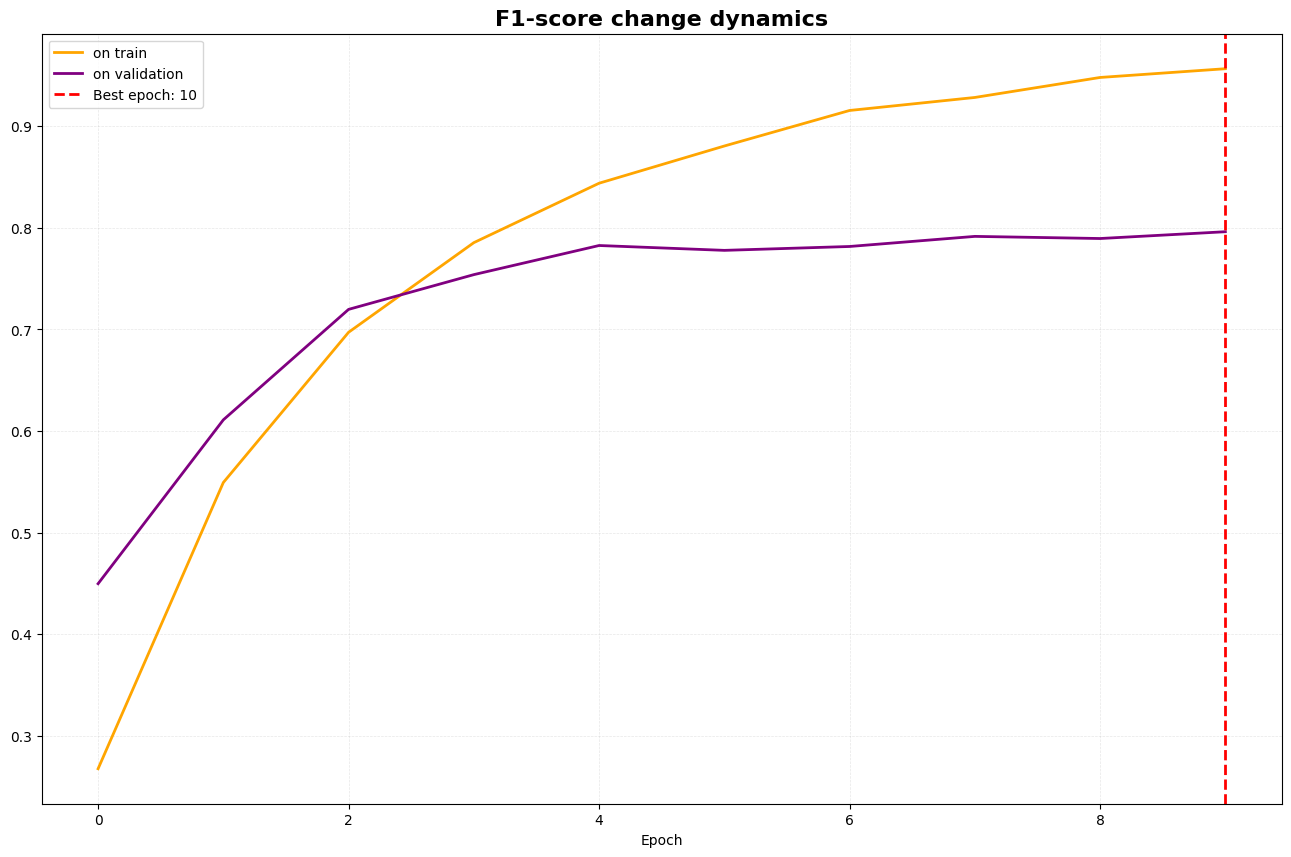

In [ ]:
def plot_dynamics(f1_score_base, max_epochs):
  plt.figure(figsize=(16, 10))
  plt.title('F1-score change dynamics', fontsize=16, fontweight='bold')
  plt.plot(range(max_epochs), f1_score_base['train'], label="on train", linewidth=2, color = 'orange')
  plt.plot(range(max_epochs), f1_score_base['valid'], label="on validation", linewidth=2, color = 'purple')
  max_f1_val = max(f1_score_base['valid'])
  max_f1_epoch = f1_score_base['valid'].index(max_f1_val)
  plt.axvline(x=max_f1_epoch, color='red', linestyle='--', linewidth=2, label=f'Best epoch: {max_f1_epoch+1}')
  plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
  plt.legend()
  plt.xlabel("Epoch")

plot_dynamics(f1_score_base, max_epochs=max_epochs)

In [ ]:
print(f'F1_score on base model: {f1_score_base['valid'][-1]}')

F1_score on base model: 0.796140619029423


Таким образом, базовая модель, обученная на 10 эпохах, дает качество (f1-score) 0.79

Сделаем визуализацию, чтобы посмотреть насколько сеть уверена в своих ответах

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

@torch.no_grad()
def show_images2(n_rows, n_cols, dataset, model):
  # функция выводит изображения в n_rows рядов и n_cols столбцов
  fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 4, n_rows * 4), \
                        sharey=True, sharex=True)

  for fig_x in axs.flatten():
    random_characters = int(np.random.uniform(0, len(dataset))) # берем случайное число в диапазоне [0; len(dataset))
    im_val, label = dataset[random_characters] # выводим изображение (тензорная форма)
    img_label = " ".join(map(lambda x: x.capitalize(), \
                             label_encoder.inverse_transform([label])[0].split('_')))  # числовую метку класса преобразуем в текстовую и немного отформатируем
    imshow(im_val.data.cpu(), title=img_label, plt_ax=fig_x) # отобразим изображение и метку класса с помощью написанной ранее функции imshow()

    # ниже представлен код для добавления на изображение подписи с вероятностью класса
    actual_text = "Actual : {}".format(img_label)


    font0 = FontProperties()
    font = font0.copy()

    # наша модель возвращает логиты, поэтому для получения вероятностей классов не забываем применить softmax:
    prob_pred = nn.functional.softmax(model(im_val.unsqueeze(0).to(DEVICE)), dim = -1).cpu().numpy()

    predicted_proba = np.max(prob_pred)*100 # берем максимальную вероятность класса
    y_pred = np.argmax(prob_pred) # берем числовую метку класса, для которого вероятность максимальна

    predicted_label = " ".join(map(lambda x: x.capitalize(), \
                             label_encoder.inverse_transform([y_pred])[0].split('_')))
    predicted_text = "{}:\n {:.1f}%".format(predicted_label, predicted_proba)

    fig_x.add_patch(patches.Rectangle((0, 190), 7*len(predicted_label), 25,color='white'))
    fig_x.text(2, 195, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')
    fig_x.set_axis_off()

  return None

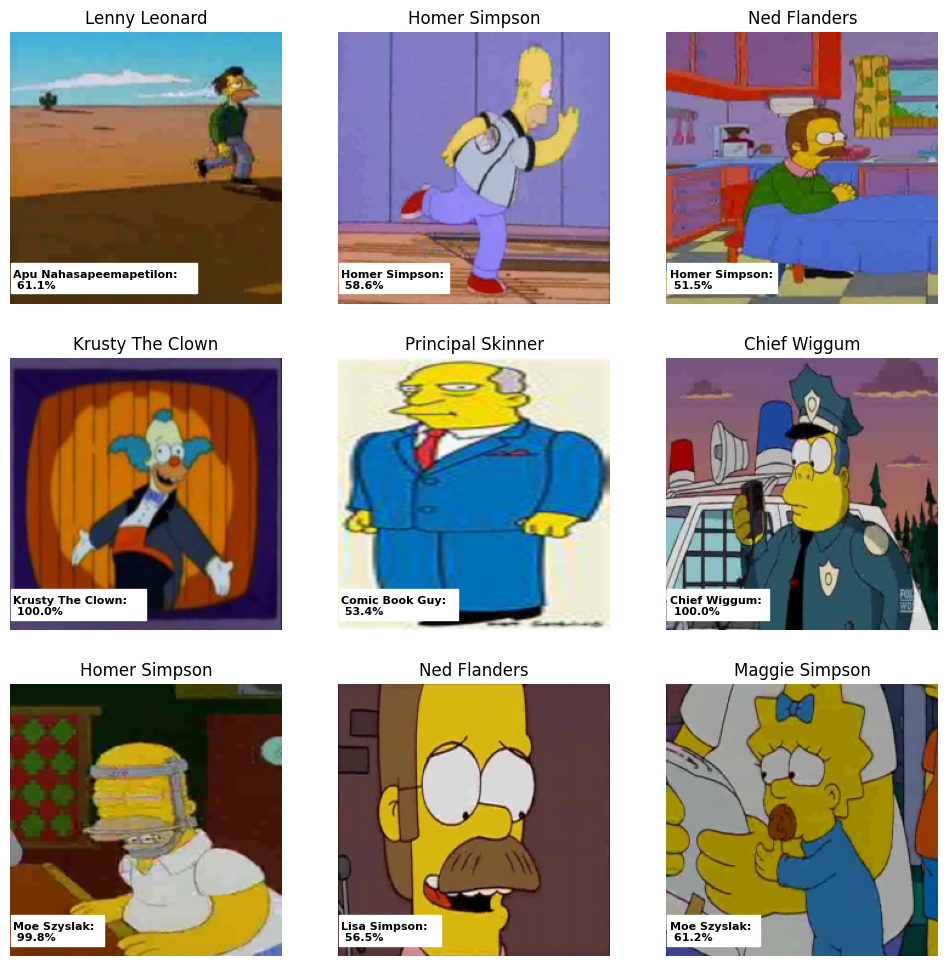

In [ ]:
show_images2(n_rows = 3, n_cols = 3, dataset = val_dataset, model = model_simple_cnn)

Таким образом, базовая сеть допускает много ошибок

In [ ]:
def predict(model, loader):
    model.eval()
    all_predictions = torch.tensor([]).to(DEVICE).int()
    print("Test mode...")
    for inputs in tqdm(loader):
        inputs = inputs.to(DEVICE)

        with torch.no_grad():
            outputs = model(inputs)

            predictions = outputs.argmax(-1).int()
            all_predictions = torch.cat((all_predictions, predictions), 0)
    return all_predictions.cpu()

# Шаг 6. Улучшение сети
теперь попробуем улучшить базовую сеть, чтобы получить лучшее качество классификации изображений.

### Для начала добавим аугментацию данных

- Для этого создадим класс, который будет наследоваться от SimpsonsDataset, чтобы переопределить метод transform_images_to_tensors, добавив в него аугментацию

In [ ]:
class AugmentedSimpsonsDataset(SimpsonsDataset):
    def transform_images_to_tensors(self, image):
      if self.mode == 'train':
        transform = v2.Compose([
            v2.Resize(RESCALE_SIZE),
            # Добавленная аугментация
            v2.RandomHorizontalFlip(p=0.3), # Отображает изображение по горизонтали с вер-тью 30%
            v2.RandomRotation(degrees=5), # Поворачивает изображение на случайный угол от -5 до +5
            #v2.RandomAffine(degrees=0, translate=(0.1, 0.1)), # Случайно сдвигает изображение по горизонтали и вертикали в пределах 10%, без поворота
            #v2.ColorJitter(brightness = 0.1, contrast = 0.1, saturation = 0.1), # Случайно меняет яркость, контраст и насыщенность

            v2.PILToTensor(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(NORMALIZE_MEAN, NORMALIZE_STD)
          ])
      else:
        transform = v2.Compose([
            v2.Resize(RESCALE_SIZE),
            v2.PILToTensor(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(NORMALIZE_MEAN, NORMALIZE_STD)
          ])

      tensor_transformed = transform(image)
      return(tensor_transformed)

- Применим аугментацию только к обучающей выборке

In [ ]:
train_dataset_new = AugmentedSimpsonsDataset(train_files, label_encoder=label_encoder, mode='train')

- При помощи Counter посмотрим train_dataset и посчитаем сколько раз встречается каждый персонаж

In [ ]:
from collections import Counter

all_labels = []
for i in range(len(train_dataset)):
    _, label = train_dataset[i] # Игнорируем изображения, берем только их метки
    all_labels.append(label)

# Считаем количество примеров каждого класса
class_counts = Counter(all_labels)
print("Распределение классов:")
for label, count in sorted(class_counts.items()):
    class_name = train_dataset.label_encoder.inverse_transform([label])[0]
    print(f"  {class_name}: {count} images")

Распределение классов:
  abraham_grampa_simpson: 685 images
  agnes_skinner: 32 images
  apu_nahasapeemapetilon: 467 images
  barney_gumble: 80 images
  bart_simpson: 1006 images
  carl_carlson: 74 images
  charles_montgomery_burns: 895 images
  chief_wiggum: 739 images
  cletus_spuckler: 35 images
  comic_book_guy: 352 images
  disco_stu: 6 images
  edna_krabappel: 343 images
  fat_tony: 20 images
  gil: 20 images
  groundskeeper_willie: 91 images
  homer_simpson: 1684 images
  kent_brockman: 373 images
  krusty_the_clown: 904 images
  lenny_leonard: 233 images
  lionel_hutz: 2 images
  lisa_simpson: 1015 images
  maggie_simpson: 96 images
  marge_simpson: 968 images
  martin_prince: 53 images
  mayor_quimby: 185 images
  milhouse_van_houten: 809 images
  miss_hoover: 13 images
  moe_szyslak: 1089 images
  ned_flanders: 1090 images
  nelson_muntz: 269 images
  otto_mann: 24 images
  patty_bouvier: 54 images
  principal_skinner: 895 images
  professor_john_frink: 49 images
  rainier_wo

Как видно из вывода кода, классы несбалансированные: есть редкие изображения и изображения, которые встречаются часто
- Поробуем применить WeightedRandomSampler, который рассчитает правило, как загружать данные DataLoader'у.

In [ ]:
from torch.utils.data import WeightedRandomSampler

class_weights = {}
for label, count in class_counts.items():
    class_weights[label] = 1.0 / count
sample_weights = [class_weights[label] for label in all_labels]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True # Разрешаем дублирование (взять изображение несколько раз)
)


In [ ]:
train_loader_new = DataLoader(train_dataset_new, batch_size=batch_size, sampler=sampler, shuffle=False)
loaders['train'] = train_loader_new

### Немного улучшим текущую базовую модель

- Для этого добавим Batch Normalization и Dropout

In [ ]:
class MoreImprovedCnn(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        #self.adaptive_pool = nn.AdaptiveAvgPool2d((5, 5))

        self.linear_layers = nn.Sequential(
            nn.Dropout(0.5), # 50% нейронов отключаем
            nn.Linear(96 * 5 * 5, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, n_classes)
        )


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        #x = self.adaptive_pool(x)

        x = x.view(x.size(0), -1)
        logits = self.linear_layers(x)
        return logits

- Вместо Adam попробуем AdamW
- Добавим scheduler, который будет каждые 4 эпохи уменьшать learning rate в 2 раза

In [ ]:
improved_model = MoreImprovedCnn(n_classes = len(np.unique(train_val_labels)))
improved_model.to(DEVICE)

MoreImprovedCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(improved_model.parameters(), lr=1e-3)
sheduler = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.5)

In [ ]:
max_epochs = 5
f1_score_improved_base = full_cycle_train(model=improved_model, dataloaders=loaders, optimizer=optimizer, loss_func=criterion, max_epochs=max_epochs)


Epoch: 1


  0%|          | 0/246 [00:00<?, ?it/s]

 F1-score train: 0.4948722848589082



  0%|          | 0/82 [00:00<?, ?it/s]

F1_score test: 0.5366832250668705


Epoch: 2


  0%|          | 0/246 [00:00<?, ?it/s]

 F1-score train: 0.7325944327664182



  0%|          | 0/82 [00:00<?, ?it/s]

F1_score test: 0.6119602598395109


Epoch: 3


  0%|          | 0/246 [00:00<?, ?it/s]

 F1-score train: 0.7900503216765399



  0%|          | 0/82 [00:00<?, ?it/s]

F1_score test: 0.7067252579289263


Epoch: 4


  0%|          | 0/246 [00:00<?, ?it/s]

 F1-score train: 0.8315816294031467



  0%|          | 0/82 [00:00<?, ?it/s]

F1_score test: 0.7363393198318685


Epoch: 5


  0%|          | 0/246 [00:00<?, ?it/s]

 F1-score train: 0.8542582330084719



  0%|          | 0/82 [00:00<?, ?it/s]

F1_score test: 0.7462743599541459



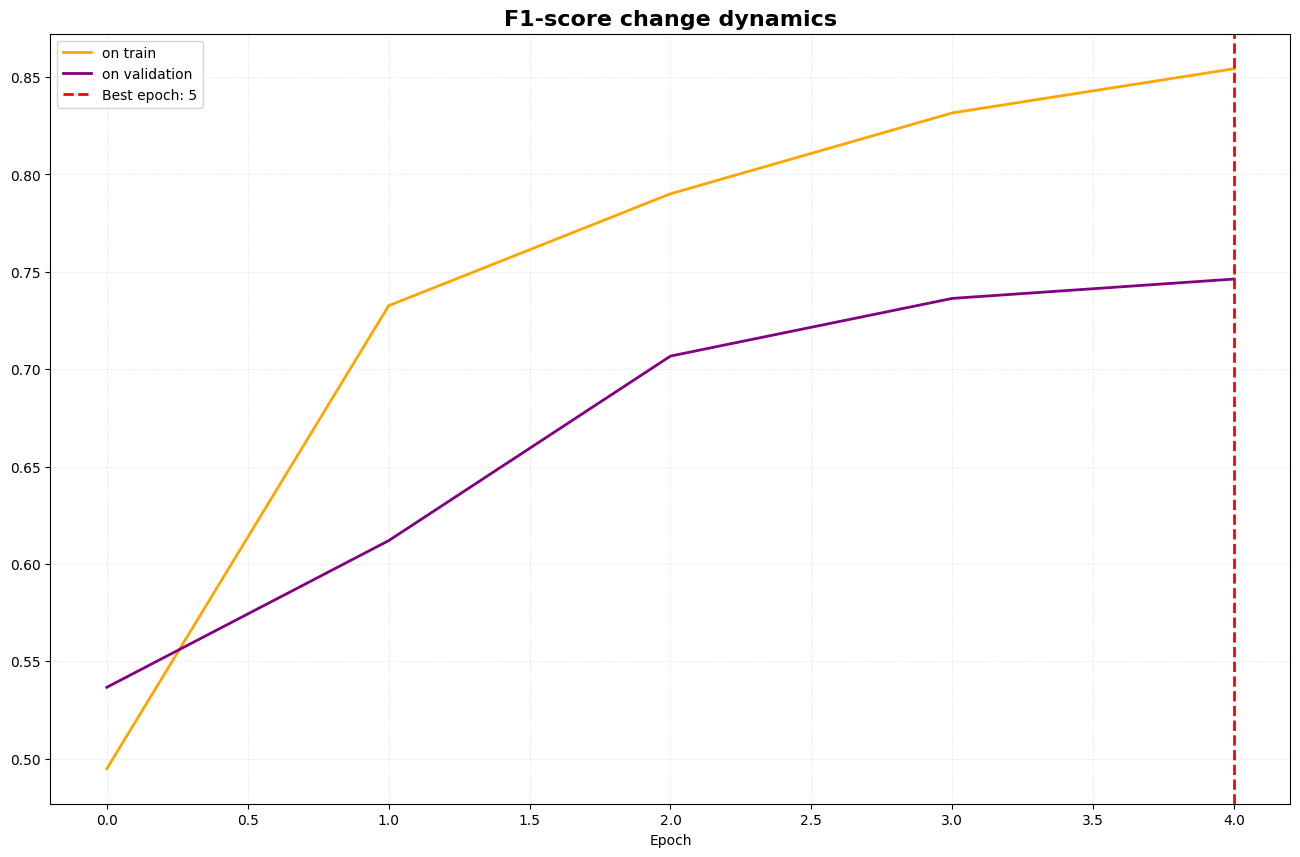

In [ ]:
plot_dynamics(f1_score_improved_base, max_epochs=max_epochs)

In [ ]:
print(f'F1_score on improved base model: {f1_score_improved_base['valid'][-1]}')

F1_score on improved base model: 0.7462743599541459


Улучшенная модель на 5 эпохах показала качетсво 0.74 на сбалансированных батчах. Это нелучший результат этой модели (см. чуть ниже заметка из прошлого)

Заметка из прошлого (до использования WeightedRandomSampler):
Немного улучшенная модель показала результаты лучше на 5 эпохах (0.83), чем базовая на 10 эпохах (0.79). К тому же улучшенная модель стала меньше переобучаться.

Таким образом, на данной модели WeightedRandomSampler показал результат хуже. Это произошло скорее всего из-за того, что редкие примеры, которые встречаются менее 10 раз стали встречатся в каждом батче, в этих картинках модель не видит новые закономерности, поэтому возможно будет переобучение. Эту ситуацию может спасти дополнительная аугментация редких классов, но пока просто оставим обычные несбалансированные классы в DataLoaders.

In [ ]:
train_dataset_new = AugmentedSimpsonsDataset(train_files, label_encoder=label_encoder, mode='train')
train_loader_new = DataLoader(train_dataset_new, batch_size=batch_size, shuffle=True)
loaders['train'] = train_loader_new

### Поробуем Transfer learning

- Дообучим модель ResNet18

In [ ]:
import torchvision.models as models

In [ ]:
model_resnet = models.resnet18(pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
from torchsummary import summary
summary(model_resnet.cuda(), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
class my_ResNet18(nn.Module):
  def __init__(self, n_classes):
    super().__init__()
    self.origin_resnet = models.resnet18(pretrained=True)

    for param in list(self.origin_resnet.parameters())[:-20]:
            param.requires_grad = False

    # Заменяем последний слой
    self.origin_resnet.fc = nn.Linear(self.origin_resnet.fc.in_features, n_classes)
  def forward(self, x):
      return self.origin_resnet(x)

In [ ]:
model_resnet18 = my_ResNet18(n_classes=len(np.unique(train_val_labels)))
model_resnet18.to(DEVICE)

my_ResNet18(
  (origin_resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

In [ ]:
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model_resnet18.parameters()),
    lr=1e-4,
    weight_decay=1e-4
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)
max_epochs = 10
f1_score_rn18 = full_cycle_train(model=model_resnet18, dataloaders=loaders, optimizer=optimizer, loss_func=criterion, max_epochs=max_epochs)


Epoch: 1


  0%|          | 0/246 [00:00<?, ?it/s]

 F1-score train: 0.763360723612969



  0%|          | 0/82 [00:00<?, ?it/s]

F1_score test: 0.9082919373328239


Epoch: 2


  0%|          | 0/246 [00:00<?, ?it/s]

 F1-score train: 0.9321612841582266



  0%|          | 0/82 [00:00<?, ?it/s]

F1_score test: 0.9340848299579672


Epoch: 3


  0%|          | 0/246 [00:00<?, ?it/s]

 F1-score train: 0.9692337091534493



  0%|          | 0/82 [00:00<?, ?it/s]

F1_score test: 0.9447841039358044


Epoch: 4


  0%|          | 0/246 [00:00<?, ?it/s]

 F1-score train: 0.9868781451047838



  0%|          | 0/82 [00:00<?, ?it/s]

F1_score test: 0.9545280855941918


Epoch: 5


  0%|          | 0/246 [00:00<?, ?it/s]

 F1-score train: 0.9928657876297854



  0%|          | 0/82 [00:00<?, ?it/s]

F1_score test: 0.9549102025219717


Epoch: 6


  0%|          | 0/246 [00:00<?, ?it/s]

 F1-score train: 0.9964328938148926



  0%|          | 0/82 [00:00<?, ?it/s]

F1_score test: 0.9545280855941918


Epoch: 7


  0%|          | 0/246 [00:00<?, ?it/s]

 F1-score train: 0.9976431619848398



  0%|          | 0/82 [00:00<?, ?it/s]

F1_score test: 0.957967137944211


Epoch: 8


  0%|          | 0/246 [00:00<?, ?it/s]

 F1-score train: 0.9990445251289891



  0%|          | 0/82 [00:00<?, ?it/s]

F1_score test: 0.9589224302636606


Epoch: 9


  0%|          | 0/246 [00:00<?, ?it/s]

 F1-score train: 0.9987897318300528



  0%|          | 0/82 [00:00<?, ?it/s]

F1_score test: 0.957967137944211


Epoch: 10


  0%|          | 0/246 [00:00<?, ?it/s]

 F1-score train: 0.9986623351805848



  0%|          | 0/82 [00:00<?, ?it/s]

F1_score test: 0.9600687810470003



In [ ]:
predicted_numeric_labels_resnet = predict(model_resnet18, test_loader)
predicted_text_labels_resnet = label_encoder.inverse_transform(predicted_numeric_labels_resnet)
my_submission_resnet = pd.DataFrame({'Id': [path.name for path in test_files], 'Expected': predicted_text_labels_resnet})
my_submission_resnet.head(10)
my_submission_resnet.to_csv('resnet18_on8.csv', index=False)

Дообученная на 20 последних слоях модель на ResNet показала качество на валидации 0.95 (лучший 0.96). Заметим, что модель сразу (уже примерно с 3 эпохи) начала сильно переобучаться. Это связано в большей степени с большим количеством обучаемых слоёв (помимо этого есть еще много причин переобучения).

- Попробуем модель EfficientNet
  - Учтем ошибки прошлого и обучим меньше слоёв

In [ ]:
class my_EfficientNet(nn.Module):
  def __init__(self, n_classes):
    super().__init__()
    self.origin_efnet = models.efficientnet_b0(pretrained=True)

    for param in list(self.origin_efnet.parameters())[:-10]:
            param.requires_grad = False

    self.origin_efnet.classifier[1] = nn.Linear(self.origin_efnet.classifier[1].in_features, n_classes)

  def forward(self, x):
      return self.origin_efnet(x)

In [ ]:
model_efnet = my_EfficientNet(n_classes=len(np.unique(train_val_labels)))
model_efnet.to(DEVICE)
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model_efnet.parameters()),
    lr=1e-4,
    weight_decay=1e-4
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)
criterion = nn.CrossEntropyLoss()
max_epochs = 15

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
f1_score_efnet = full_cycle_train(model=model_efnet, dataloaders=loaders, optimizer=optimizer, loss_func=criterion, max_epochs=max_epochs)


Epoch: 1


  0%|          | 0/246 [00:00<?, ?it/s]

 F1-score train: 0.3674756353907892



  0%|          | 0/82 [00:00<?, ?it/s]

F1_score test: 0.6175009552923194


Epoch: 2


  0%|          | 0/246 [00:00<?, ?it/s]

 F1-score train: 0.6468564876743742



  0%|          | 0/82 [00:00<?, ?it/s]

F1_score test: 0.7178066488345434


Epoch: 3


  0%|          | 0/246 [00:00<?, ?it/s]

 F1-score train: 0.7235492706541818



  0%|          | 0/82 [00:00<?, ?it/s]

F1_score test: 0.7711119602598395


Epoch: 4


  0%|          | 0/246 [00:00<?, ?it/s]

 F1-score train: 0.7668004331486082



  0%|          | 0/82 [00:00<?, ?it/s]

F1_score test: 0.7928926251432938


Epoch: 5


  0%|          | 0/246 [00:00<?, ?it/s]

 F1-score train: 0.7980763105930314



  0%|          | 0/82 [00:00<?, ?it/s]

F1_score test: 0.8175391669850974


Epoch: 6


  0%|          | 0/246 [00:00<?, ?it/s]

 F1-score train: 0.8199248359768138



  0%|          | 0/82 [00:00<?, ?it/s]

F1_score test: 0.8297669086740542


Epoch: 7


  0%|          | 0/246 [00:00<?, ?it/s]

 F1-score train: 0.8367411937066055



  0%|          | 0/82 [00:00<?, ?it/s]

F1_score test: 0.842185708826901


Epoch: 8


  0%|          | 0/246 [00:00<?, ?it/s]

 F1-score train: 0.8489712720555449



  0%|          | 0/82 [00:00<?, ?it/s]

F1_score test: 0.8460068781047


Epoch: 9


  0%|          | 0/246 [00:00<?, ?it/s]

 F1-score train: 0.858589719090388



  0%|          | 0/82 [00:00<?, ?it/s]

F1_score test: 0.8597630875047765


Epoch: 10


  0%|          | 0/246 [00:00<?, ?it/s]

 F1-score train: 0.8698006242435824



  0%|          | 0/82 [00:00<?, ?it/s]

F1_score test: 0.8647306075659151


Epoch: 11


  0%|          | 0/246 [00:00<?, ?it/s]

 F1-score train: 0.8770622332632652



  0%|          | 0/82 [00:00<?, ?it/s]

F1_score test: 0.8727550630492931


Epoch: 12


  0%|          | 0/246 [00:00<?, ?it/s]

 F1-score train: 0.8830498757882668



  0%|          | 0/82 [00:00<?, ?it/s]

F1_score test: 0.8779136415743217


Epoch: 13


  0%|          | 0/246 [00:00<?, ?it/s]

 F1-score train: 0.891903942926301



  0%|          | 0/82 [00:00<?, ?it/s]

F1_score test: 0.8859380970576997


Epoch: 14


  0%|          | 0/246 [00:00<?, ?it/s]

 F1-score train: 0.8968087139308236



  0%|          | 0/82 [00:00<?, ?it/s]

F1_score test: 0.8851738632021399


Epoch: 15


  0%|          | 0/246 [00:00<?, ?it/s]

KeyboardInterrupt: 

Таким образом, у меня получилась ResNet лучшей моделью. EfficientNet меньше переобучается, качество с эпохами растет, однако модели требуется намного больше эпох для обучения.

In [ ]:
predicted_numeric_labels_efnet = predict(model_efnet, test_loader)
predicted_text_labels_efnet = label_encoder.inverse_transform(predicted_numeric_labels_efnet)
my_submission_efnet = pd.DataFrame({'Id': [path.name for path in test_files], 'Expected': predicted_text_labels_efnet})
my_submission_efnet.head(10)
my_submission_efnet.to_csv('efnet_on10.csv', index=False)

Test mode...


  0%|          | 0/16 [00:00<?, ?it/s]